## Training loop (WIP)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import glob


import numpy as np
import pandas as pd
import sklearn.model_selection
import torch 
import torchvision
import rasterio as rio
import matplotlib.pyplot as plt


from models.resnet18 import ResNet18
from data_handlers.datasets.csv_dataset import CustomDatasetFromDataFrame
from utils import transfer_learning as tl

/home/matthieu/anaconda3/envs/mpa_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
CSV_PATH=os.path.join('data','geometry_less_dataset.csv')
DATA_DIR=os.path.join('data','landsat_tif','')

In [22]:
# Add filenames:
csv = pd.read_csv(CSV_PATH)
csv['filename']=csv.apply(
    lambda row:  str(row['lat'])[:5].replace('.','_')+"_"+str(row.lon)[:5].replace('.','_')+'.tif', axis=1
)
csv = csv.loc[:, ~csv.columns.str.contains('^Unnamed')]
csv.head()

,country,year,cluster,lat,lon,households,wealthpooled,filename
0,angola,2011,1,-12.350257,13.534922,36,2.312757,-12_3_13_53.tif
1,angola,2011,2,-12.360865,13.551494,32,2.010293,-12_3_13_55.tif
2,angola,2011,3,-12.613421,13.413085,36,0.877744,-12_6_13_41.tif
3,angola,2011,4,-12.581454,13.397711,35,1.066994,-12_5_13_39.tif
4,angola,2011,5,-12.578135,13.418748,37,1.750153,-12_5_13_41.tif


In [13]:
# AND SAVE UPDATED CSV
# csv.drop(csv.loc[(csv['country']=='kenya')&(csv['year']==2014)].index, inplace=True)
# csv.drop(csv.loc[(csv['country']=='nigeria')&(csv['year']==2018)].index, inplace=True)
# csv.drop(csv.loc[(csv['country']=='ethiopia')&(csv['year']==2016)].index, inplace=True)
# csv.drop(csv.loc[(csv['country']=='ethiopia')&(csv['year']==2019)].index, inplace=True)
csv.to_csv(CSV_PATH, index=False)

In [16]:
def show_sample(tile, label, swap_br=True):
    tile_rgb = tile[:3,:,:].numpy()
    tile_rgb = tile_rgb.transpose((1,2,0))
    tile_rgb = (tile_rgb-tile_rgb.min() )/ (tile_rgb.max()-tile_rgb.min())
    print(tile_rgb.min(), " __ ", tile_rgb.max())
    if swap_br:
        tile_rgb=tile_rgb[:,:,::-1]
    plt.figure()
    plt.imshow((tile_rgb*255).astype(int))
    plt.title('wealth index: '+str(label))
    plt.show()
    return

In [35]:
# COMPUTE MEAN AND STD OF THE WHOLE DATASET
# (DO IT ONCE)
tile_names=glob.glob(os.path.join(DATA_DIR)+'*.tif')
tiles=torch.stack([torch.from_numpy(np.nan_to_num(np.array(rio.open(tile).read())[:,:186,:186])) for tile in tile_names])
means = tiles.view(7, -1).mean(dim=1)
stds = tiles.view(7, -1).std(dim=1)
print(means, stds)
# last output:
# tensor([42.7178, 42.9092, 43.2119, 42.8700, 42.7862, 42.7192, 42.8525]) 
# tensor([104.3150, 104.7388, 105.4271, 104.6307, 104.5374, 104.3182, 104.5891])

tensor([42.7178, 42.9092, 43.2119, 42.8700, 42.7862, 42.7192, 42.8525]) tensor([104.3150, 104.7388, 105.4271, 104.6307, 104.5374, 104.3182, 104.5891])


In [17]:
train_transform = torch.nn.Sequential(
    torchvision.transforms.Resize(size=224),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.Normalize(
        mean=[42.7178, 42.9092, 43.2119, 42.8700, 42.7862, 42.7192, 42.8525],
        std =[104.3150, 104.7388, 105.4271, 104.6307, 104.5374, 104.3182, 104.5891]
        )
)
test_transform  = torch.nn.Sequential(
    torchvision.transforms.Resize(size=224),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.Normalize(
        mean=[42.7178, 42.9092, 43.2119, 42.8700, 42.7862, 42.7192, 42.8525],
        std =[104.3150, 104.7388, 105.4271, 104.6307, 104.5374, 104.3182, 104.5891]
        )
)

In [24]:
cluster_splits = sklearn.model_selection.train_test_split(np.arange(len(csv.cluster.unique())))
# train test split
train_split = np.array([idx for i in cluster_splits[0] for idx,_ in csv[csv.cluster==i].iterrows()])
test_split  = np.array([idx for i in cluster_splits[1] for idx,_ in csv[csv.cluster==i].iterrows()])
# train val split
np.random.shuffle(train_split)
train_split, val_split = train_split[:int(0.8*len(train_split))], train_split[int(0.8*len(train_split)):]

In [25]:
train_df = csv.iloc[train_split]
val_df = csv.iloc[val_split]
test_df = csv.iloc[test_split]

train_dataset = CustomDatasetFromDataFrame(train_df, DATA_DIR, transform=train_transform)
val_dataset = CustomDatasetFromDataFrame(val_df, DATA_DIR, transform=train_transform)
test_dataset  = CustomDatasetFromDataFrame(test_df, DATA_DIR, transform=test_transform)

2. Model

In [50]:
with open('configs/resnet18_ms.json') as f:
    config = json.load(f)
    model = ResNet18(config, train_set=train_dataset, val_set=val_dataset)
    model.model = tl.update_first_layer(model=model.model, in_channels=7, weights_init='average', scaling=4/7)
    model.model = tl.update_last_layer(model=model.model, out_features=1)

In [51]:
model.train()

Train Epoch: 0 [0/19439 (0%)]	Loss: 1.617497
Train Epoch: 0 [800/19439 (4%)]	Loss: 0.395517


0 torch.Size([7, 224, 224]) -0.3722147
0.0  __  1.0


<Figure size 640x480 with 0 Axes>

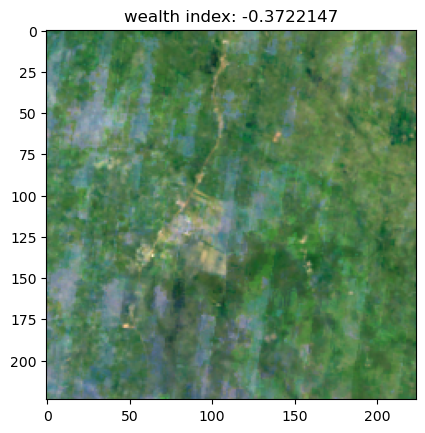

1 torch.Size([7, 224, 224]) -0.90676194
0.0  __  1.0


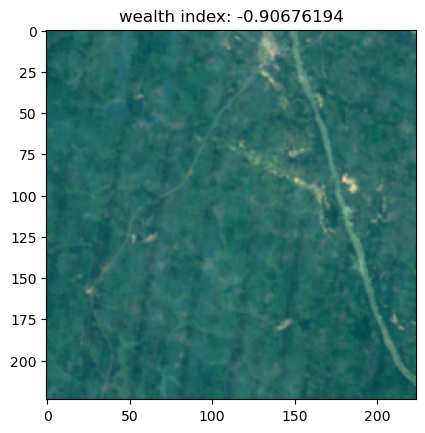

In [86]:
fig = plt.figure()

for i in range(0,2):
    sample = train_dataset[i]
    print(i, sample['tile'].shape, sample['value'])
    show_sample(sample['tile'], sample['value'])